In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-insurance-premium-prediction/Medicalpremium.csv


In [2]:
# importing libraries

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRFRegressor

In [3]:
# reading data
data = pd.read_csv('/kaggle/input/medical-insurance-premium-prediction/Medicalpremium.csv')
data

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000


# Exploratory Data Analysis

In [4]:
# check data types
data.dtypes

Age                        int64
Diabetes                   int64
BloodPressureProblems      int64
AnyTransplants             int64
AnyChronicDiseases         int64
Height                     int64
Weight                     int64
KnownAllergies             int64
HistoryOfCancerInFamily    int64
NumberOfMajorSurgeries     int64
PremiumPrice               int64
dtype: object

In [5]:
# checking for null values
data.isnull().sum()

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice               0
dtype: int64

In [6]:
# checking for duplicates
data.duplicated().sum()

0

In [7]:
# renaming columns for easier reference
data = data.rename(columns={"BloodPressureProblems":"BPProblems", "AnyTransplants":"Transplants", "AnyChronicDiseases":"Diseases", "KnownAllergies":"Allergies", "HistoryOfCancerInFamily":"CancerFHx", "NumberOfMajorSurgeries":"Surgeries", "PremiumPrice":"Premium"})
data

,Age,Diabetes,BPProblems,Transplants,Diseases,Height,Weight,Allergies,CancerFHx,Surgeries,Premium
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000


### Checking for outliers

In [8]:
# roughly checking for possible outliers numerically
data.describe()

,Age,Diabetes,BPProblems,Transplants,Diseases,Height,Weight,Allergies,CancerFHx,Surgeries,Premium
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,41.745436,0.419878,0.468560,0.055781,0.180527,168.182556,76.950304,0.215010,0.117647,0.667343,24336.713996
std,13.963371,0.493789,0.499264,0.229615,0.384821,10.098155,14.265096,0.411038,0.322353,0.749205,6248.184382
min,18.000000,0.000000,0.000000,0.000000,0.000000,145.000000,51.000000,0.000000,0.000000,0.000000,15000.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,161.000000,67.000000,0.000000,0.000000,0.000000,21000.000000
50%,42.000000,0.000000,0.000000,0.000000,0.000000,168.000000,75.000000,0.000000,0.000000,1.000000,23000.000000
75%,53.000000,1.000000,1.000000,0.000000,0.000000,176.000000,87.000000,0.000000,0.000000,1.000000,28000.000000
max,66.000000,1.000000,1.000000,1.000000,1.000000,188.000000,132.000000,1.000000,1.000000,3.000000,40000.000000


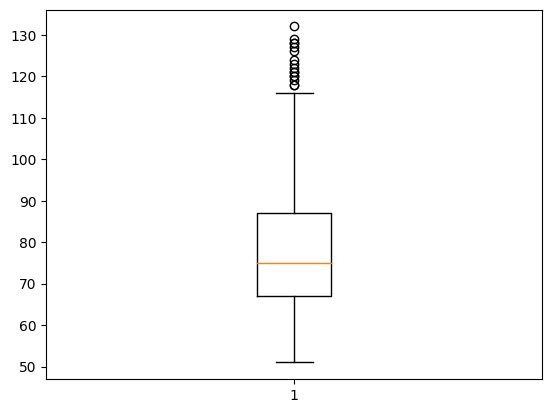

In [9]:
# checking for outliers graphically
plt.boxplot(data['Weight'])
plt.show()

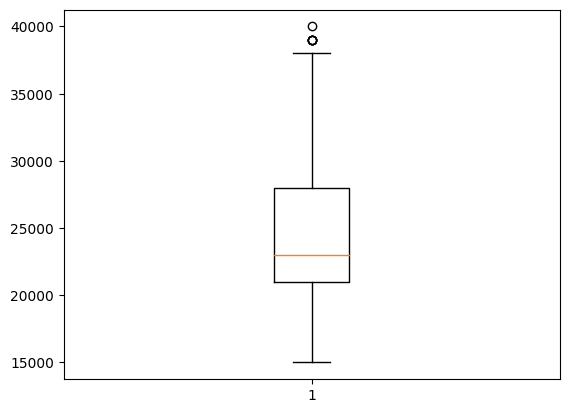

In [10]:
plt.boxplot(data['Premium'])
plt.show()

### Removing outliers

In [11]:
# adding index column to track rows removed
new_data = data.copy()
new_data['index'] = range(len(new_data))

# separating binary variables from continuous variables
bi_data = new_data.loc[:, ['index', 'Diabetes', 'BPProblems', 'Transplants', 'Diseases', 'Allergies', 'CancerFHx']]
bi_data.head()

# dropping binary data columns to use for removing outliers
new_data = new_data.drop(['Diabetes', 'BPProblems', 'Transplants', 'Diseases', 'Allergies', 'CancerFHx'], axis=1)
new_data.head()

,Age,Height,Weight,Surgeries,Premium,index
0,45,155,57,0,25000,0
1,60,180,73,0,29000,1
2,36,158,59,1,23000,2
3,52,183,93,2,28000,3
4,38,166,88,1,23000,4


In [12]:
# removing outliers using IQR
Q1 = new_data.quantile(0.25)
Q3 = new_data.quantile(0.75)
IQR = Q3 - Q1

new_data = new_data[~((new_data < (Q1 - 1.5 * IQR)) | (new_data > (Q3 + 1.5 * IQR))).any(axis=1)]

# confirming outliers removed
new_data.describe()

,Age,Height,Weight,Surgeries,Premium,index
count,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000
mean,41.478398,168.208641,76.146470,0.626976,24185.458377,495.123288
std,13.701797,10.143105,13.028719,0.691990,6160.764594,283.023240
min,18.000000,145.000000,51.000000,0.000000,15000.000000,0.000000
25%,30.000000,161.000000,67.000000,0.000000,21000.000000,256.000000
50%,42.000000,168.000000,75.000000,1.000000,23000.000000,500.000000
75%,52.000000,176.000000,86.000000,1.000000,28000.000000,738.000000
max,66.000000,188.000000,116.000000,2.000000,38000.000000,985.000000


In [13]:
# concatenating the dataframes with inner join along index column to remove outlier rows from bi_data
df = pd.concat([new_data, bi_data], axis=1, join='inner')

# dropping index column
df = df.drop(['index'], axis=1)
df.describe()

,Age,Height,Weight,Surgeries,Premium,Diabetes,BPProblems,Transplants,Diseases,Allergies,CancerFHx
count,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000
mean,41.478398,168.208641,76.146470,0.626976,24185.458377,0.415174,0.469968,0.055848,0.185458,0.218124,0.119073
std,13.701797,10.143105,13.028719,0.691990,6160.764594,0.493012,0.499360,0.229750,0.388874,0.413190,0.324045
min,18.000000,145.000000,51.000000,0.000000,15000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,161.000000,67.000000,0.000000,21000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,42.000000,168.000000,75.000000,1.000000,23000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,176.000000,86.000000,1.000000,28000.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,66.000000,188.000000,116.000000,2.000000,38000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Correlation heatmap

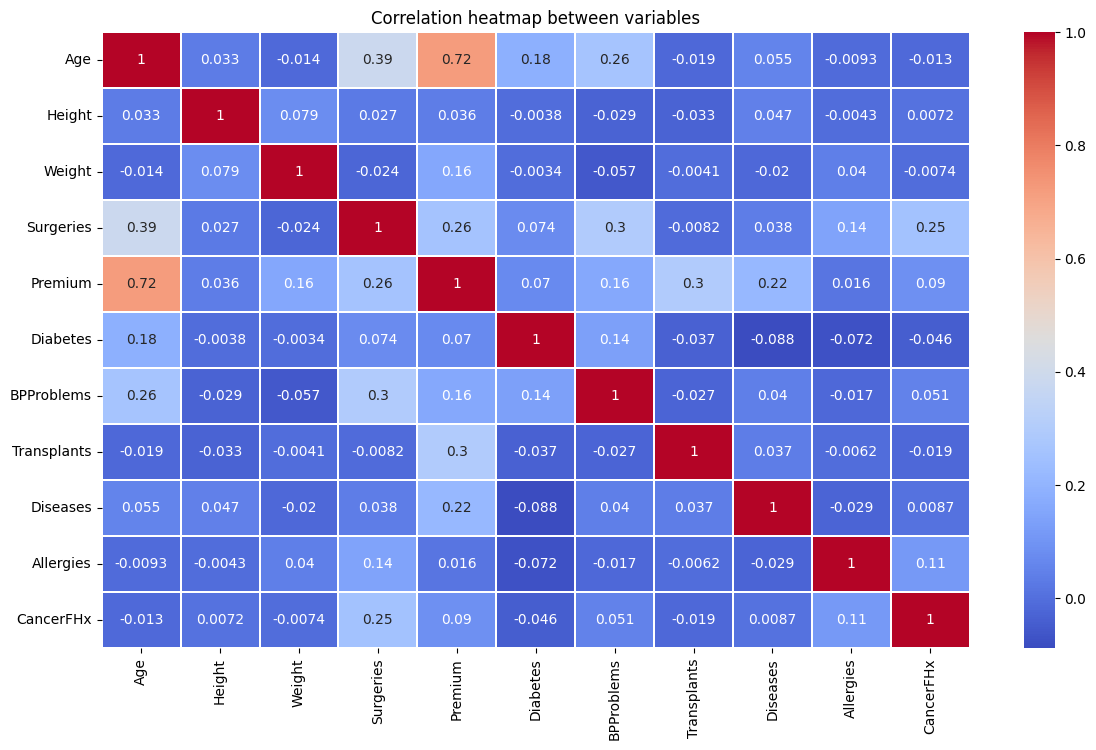

In [14]:
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.1)
plt.title("Correlation heatmap between variables")
plt.show()

# Modeling

In [15]:
# set features and prediction target
X = df.drop('Premium', axis=1)
y = df['Premium']

# split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Determing model accuracy to decide on which model(s) to use

In [16]:
models = { LinearRegression():'Linear Regression', Lasso():'Lasso', Ridge():'Ridge', XGBRFRegressor():'XGBoost Regressor', RandomForestRegressor():'Random Forest'}

# fitting data for each model
for m in models.keys():
    m.fit(X_train, y_train)
    
# printing accuracy score for each model
for model, name in models.items():
    score = model.score(X_test, y_test)*100
    print(f"{name} accuracy: ", score, "%")

Linear Regression accuracy:  65.68982111098293 %
Lasso accuracy:  65.70028390988158 %
Ridge accuracy:  65.61546775042974 %
XGBoost Regressor accuracy:  74.20484202340003 %
Random Forest accuracy:  75.06419498796505 %


### Random Forest Model

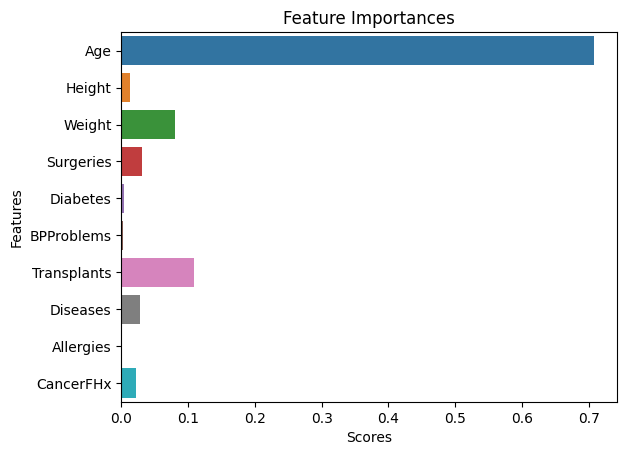

In [17]:
rand_forest = RandomForestRegressor()
rand_forest.fit(X_train, y_train)
rf_feat_import = rand_forest.feature_importances_

# graphing feature importances
sns.barplot(x=rf_feat_import, y=X.columns)
plt.title('Feature Importances')
plt.xlabel('Scores')
plt.ylabel('Features')
plt.show()

### XGBoost Regressor

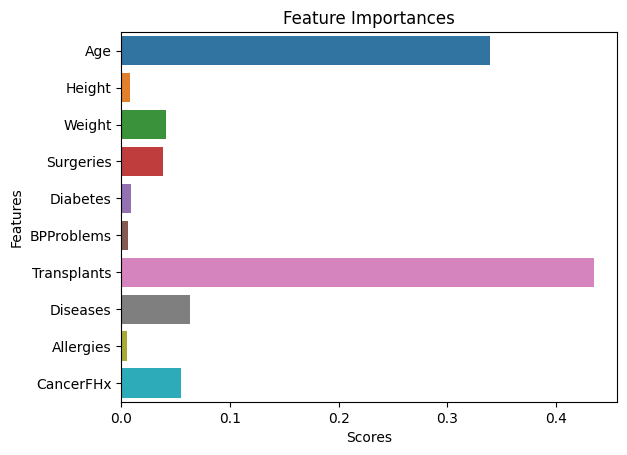

In [18]:
xgb = XGBRFRegressor()
xgb.fit(X_train, y_train)
xgb_feat = xgb.feature_importances_
sns.barplot(x=xgb_feat, y=X.columns)
plt.title('Feature Importances')
plt.xlabel('Scores')
plt.ylabel('Features')
plt.show()